In [116]:
# data stuff
import pandas as pd
import numpy as np

# bayesian stuff
import pymc3 as pm

# plotting stuff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image, HTML, display

### About this notebook:
In this chapter, we begin the exploration of bayeasian methods by analizing phone text data and utilizing PyMC to derive the posterior distributions for the underlying parameters. We answer the question: is there a difference or a change in the textting behavior of the user given the data?

#### 📚 Sources:
* "Bayesian Methods for Hackers": chapter 1, page 12.
* https://en.wikipedia.org/wiki/Poisson_distribution

---


### Import the data:

In [2]:
texts = np.loadtxt('data/txtdata.csv')

### Plot:

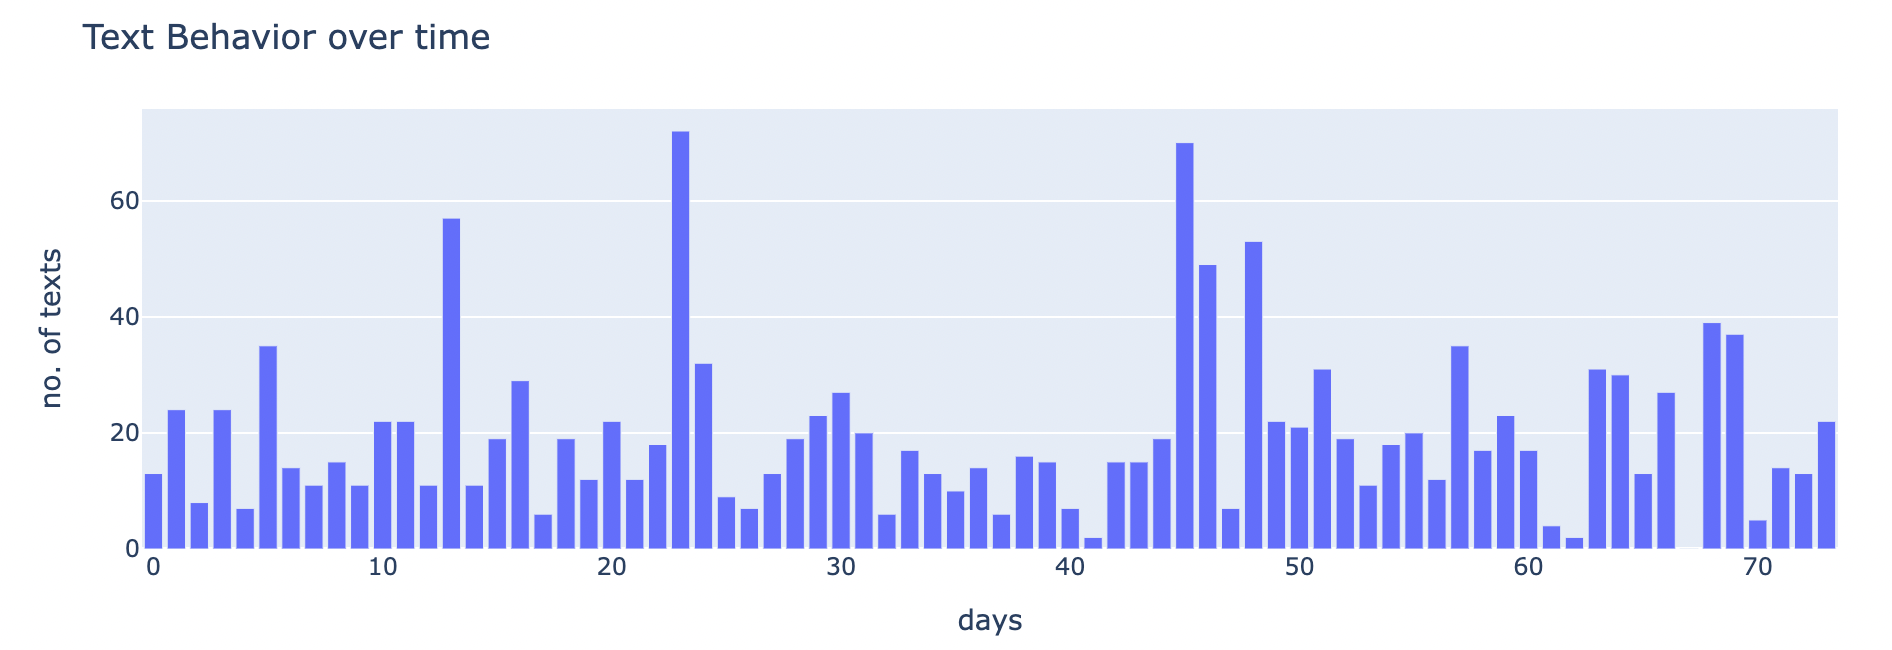

In [117]:
txt_fig = px.bar(texts)
txt_fig.update_layout(
    showlegend=False,
    title="Text Behavior over time",
    xaxis_title="days",
    yaxis_title="no. of texts",
    # legend_title="count"
)
Image(filename='./images/ch1_observed.png', width=1400)

---

### Initial Observations:
Given the data above, we want to answer the question of whether there was a change in the texting behavior of the user. 

We can model the text count using a Poisson randon variable. As per our resource, the Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known **constant mean rate** and independently of the time since the last event.

Then we can say that each day's $i$ count denoted as $C_i$ is Poisson distributed with parameter $\lambda$ (i.e. rate) as follows:
$$C_1 \sim \text{Poi}(\lambda)$$

However, we suspect that the rate ($\lambda$) in not really constant, and that it has changed after some period of time on a certain day, which we will denote by $\tau$. In effect, we are considerign the following case:

\begin{equation}
\lambda = 
     \begin{cases}
        \lambda_1, & \text{if } t < \tau\\
        \lambda_2, & \text{if } t \geq \tau
    \end{cases}
\end{equation}

We are interested in inferring what these $\lambda$s really are. But before we continue, we need to assign a prior distribution to the $\lambda$s. We will employ an exponential distribtuion for the priors. Thus, we say that:
$$\lambda_1 \sim \text{Exp}(\alpha)$$
$$\lambda_2 \sim \text{Exp}(\alpha)$$

We surmise that the $\alpha$ hyperparam in this case should not affect the model too much as a choice for the priors, thus, we set it to be the inverse of the sample average of the count data. Since exponentially distibuted variables have an expected value of:
$$X \sim \text{Exp}(\lambda)  \implies  \text{E}[X|\lambda] = \frac{1}{\lambda}$$

we can say:
$$\frac{1}{N}\sum_{i=0}^{N}C_i \approx \text{E}[\lambda|\alpha] = \frac{1}{\alpha}$$

Similarly, we need to assign a prior to $\tau$. Because of the noisiness of the data it is difficult to ascertain when the switch might have happened. So we will assign equal probability to every day by utilizing an uniform distribution, thus assigning **uniform prior belief**:
$$\tau \sim \text{DiscreteUniform}(1, 70)$$
$$\implies P(\tau = k) = \frac{1}{k}$$

---

### Set parameter priors:

In [4]:
# assign variables
n_count_data = len(texts)

import pymc3 as pm

with pm.Model() as model:
    alpha = 1.0/texts.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

&nbsp;

### Set Random Variable $\lambda$ by computing the switch function:
The code below will update the $\lambda$ random variable by switching between values of $\lambda_1$ and $\lambda_2$ based on the value of $\tau$.

In [5]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

&nbsp;

### Combine "observed" data with PyMC data generation scheme:

In [6]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=texts)

&nbsp;

### Compute posterior distributions for $\lambda_1$, $\lambda_2$, and $\tau$ and use it to learn the best fit to the observed data.

In [7]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 21 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


&nbsp;

### Extract Posterior distributions from the PyMC Trials:

In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

#### Plot distributions:

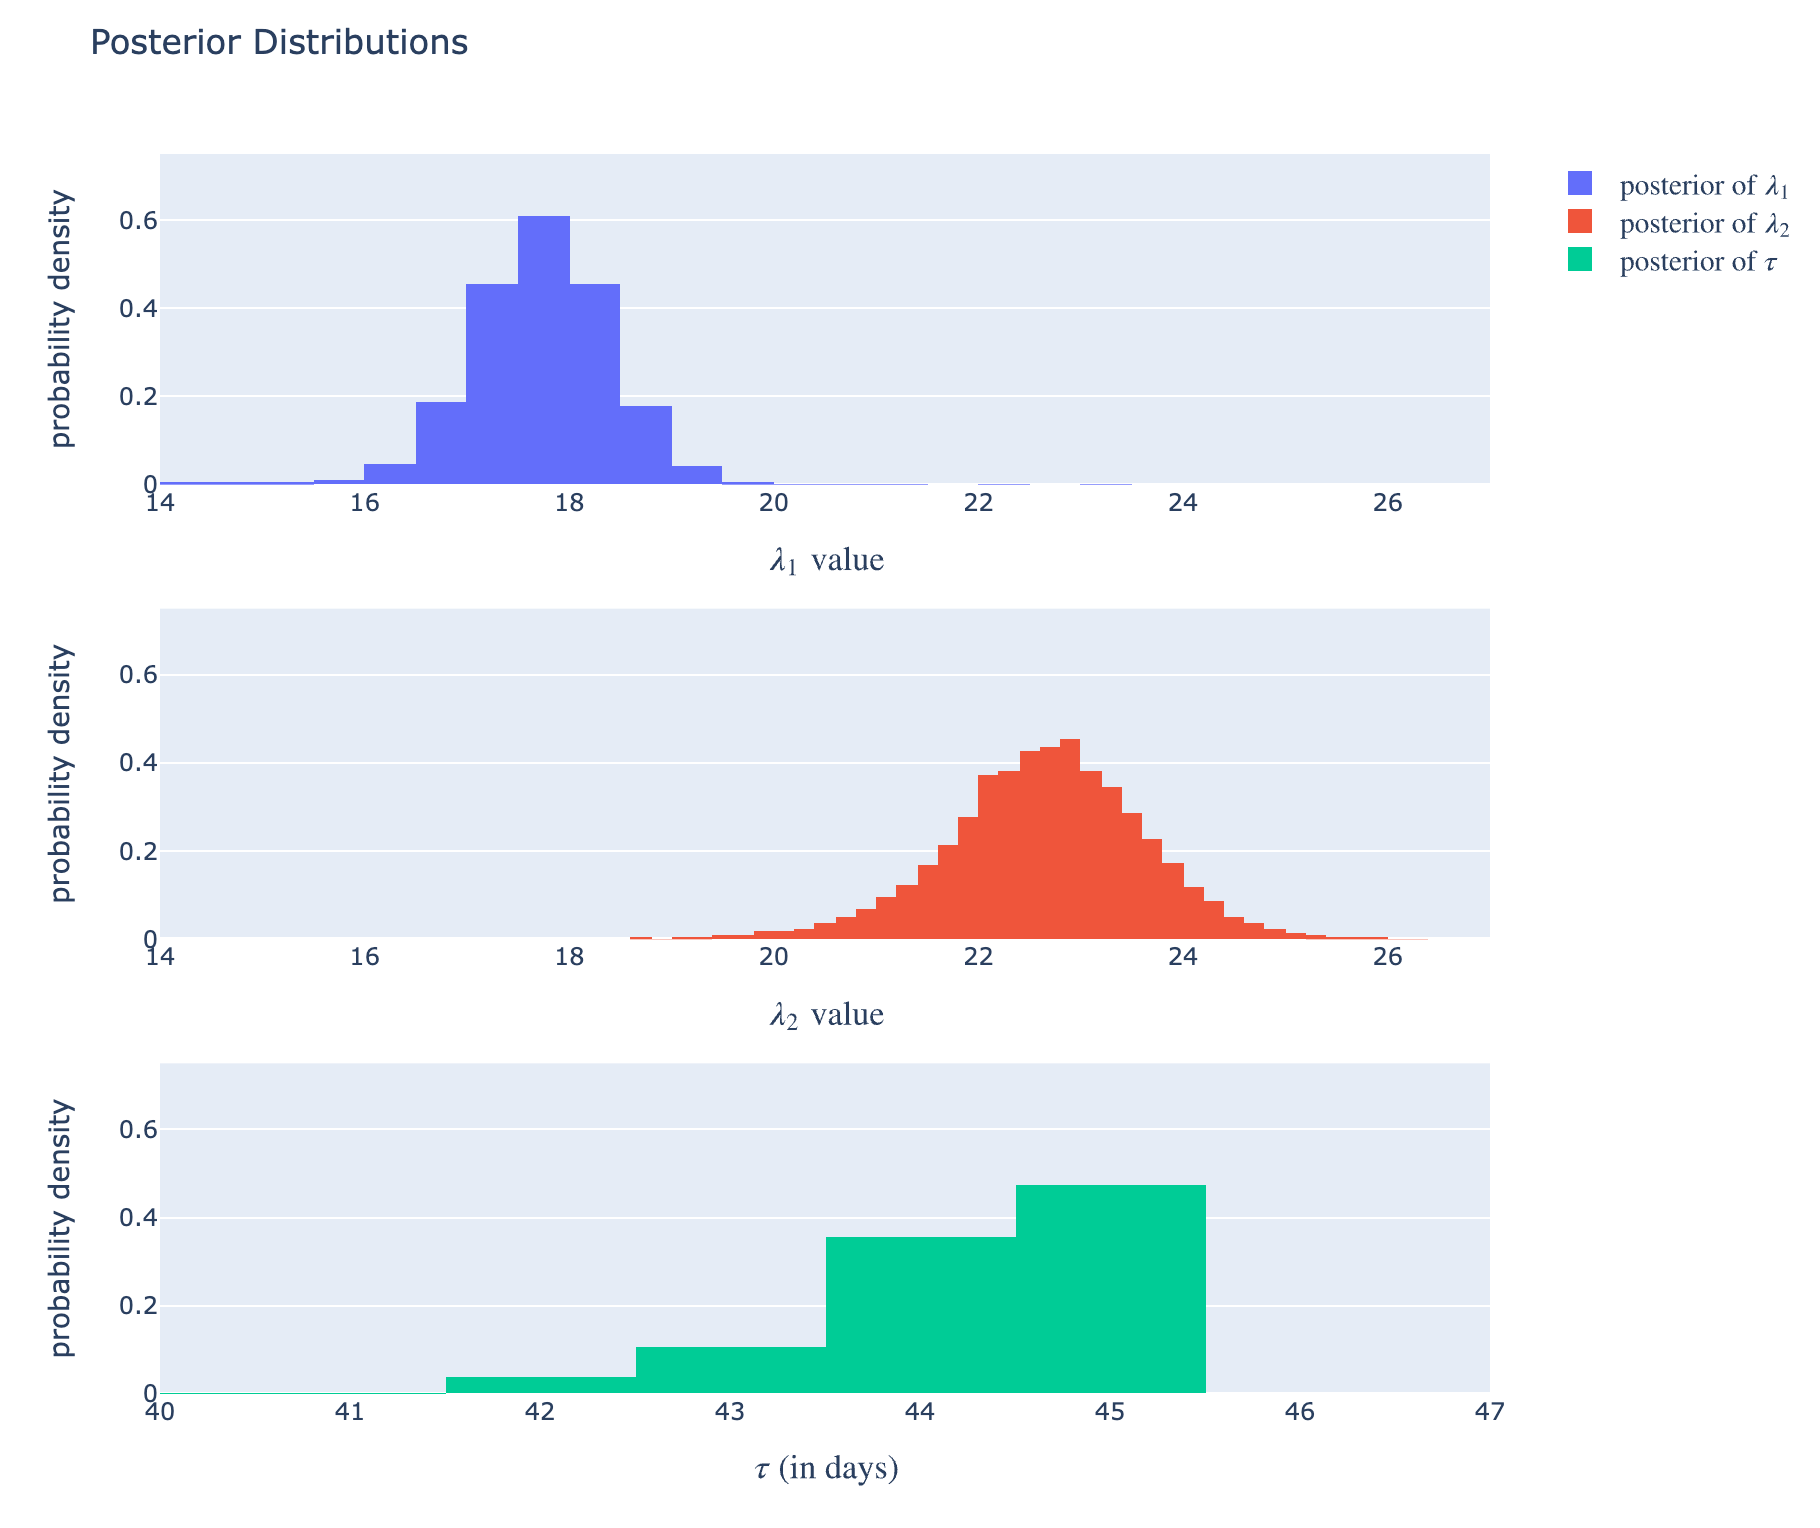

In [121]:
posterior_fig = make_subplots(rows=3, cols=1)

posterior_fig.add_trace(go.Histogram(x=lambda_1_samples, 
                                     histnorm='probability density', 
                                     nbinsx=50,
                                     name='$\\text{posterior of }\lambda_1$'), row=1, col=1)
posterior_fig.add_trace(go.Histogram(x=lambda_2_samples, 
                                     histnorm='probability density', 
                                     nbinsx=50,
                                     name='$\\text{posterior of }\lambda_2$'), row=2, col=1)
posterior_fig.add_trace(go.Histogram(x=tau_samples, 
                                     histnorm='probability density',
                                     name='$\\text{posterior of }\\tau$'), row=3, col=1)

posterior_fig.update_layout(height=800, width=900, title_text='Posterior Distributions')
posterior_fig.update_layout(xaxis1 = dict(range=[14, 27]))
posterior_fig.update_layout(xaxis2 = dict(range=[14, 27]))
posterior_fig.update_layout(xaxis3 = dict(range=[40, 47]))
posterior_fig.update_yaxes(range=[0, 0.75])

posterior_fig['layout']['xaxis1']['title']='$\lambda_1\\text{ value}$'
posterior_fig['layout']['xaxis2']['title']='$\lambda_2\\text{ value}$'
posterior_fig['layout']['xaxis3']['title']='$\\tau\\text{ (in days)}$'

posterior_fig['layout']['yaxis1']['title']='probability density'
posterior_fig['layout']['yaxis2']['title']='probability density'
posterior_fig['layout']['yaxis3']['title']='probability density'

Image(filename='./images/ch1_posteriors.png', width=1400)
# posterior_fig.show()

---

### Conclusion:
As we can see above, the posterior distributions of $\lambda_1$ and $\lambda_2$ are significantly different, indicating that there was indeed a change in the rate of text messages received. 

The $\lambda_1$ rate 

Furthermore, as the posterior distribution of $\tau$ shows, this change most likely happened around day 45, building up during the preceding days.